In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sc
np.set_printoptions(suppress=True)

In [4]:
def read_file(filename):
    names, errors, shape, loss = [], [], [], []
    with open(filename, 'r') as file:
        for line in file:
            # Split the line into its components using whitespace as the delimiter
            parts = line.strip().split()
            # Extract the "name", "val1", and "val2" from the parts list
            names.append(parts[0])
            errors.append(float(parts[1]))
            shape.append(float(parts[2]))
            if len(parts) == 4:
                loss.append(float(parts[3]))
    return names, errors, shape, loss

def checkNumVar(codeNum, varNum):
    # varNum: 1-6, codeNum: 0-63
    for i in range(varNum):
        out = int(codeNum%2)
        codeNum = int(codeNum/2)
    return out


def getCodeNumsWithVars(vars, numTotVars=7):
    codeNums = []
    for i in range(2**numTotVars):
        lst = []
        for v in vars:
            lst.append(checkNumVar(i, v))
        if (all(num == 1 for num in lst)):
            codeNums.append(i)
    return codeNums


def getCodeNumsNumVars(numVars, numTotVars=7):
    codeNums = []
    for i in range(2**numTotVars):
        lst = []
        for v in range(1, numTotVars+1):
            lst.append(checkNumVar(i, v))
        if (sum(lst) == numVars):
            codeNums.append(i)
    return codeNums

def getVarsFromCode(code):
    vars = []
    count = 0
    while code > 0:
        count += 1
        if(code%2):
            vars.append(count)
        code = int(code/2)
    return vars

def colorScale(hexColor1, hexColor2, numColors=2):
    out = []
    hexColor1, hexColor2 = hexColor1.lstrip('#'), hexColor2.lstrip('#')
    r1, g1, b1 = int(hexColor1[0:2], 16), int(hexColor1[2:4], 16), int(hexColor1[4:6], 16)
    r2, g2, b2 = int(hexColor2[0:2], 16), int(hexColor2[2:4], 16), int(hexColor2[4:6], 16)
    slope_r, slope_g, slope_b = (r2-r1)/(numColors-1), (g2-g1)/(numColors-1), (b2-b1)/(numColors-1)
    for i in range(numColors):
        out.append("#" + "{:02x}".format(int(r1+i*slope_r)).upper() + "{:02x}".format(int(g1+i*slope_g)).upper() + "{:02x}".format(int(b1+i*slope_b)).upper())
    return out

def getInterval(errVal, spacing=0.2):
    for v in np.arange(3.5, 5.001, spacing):
        if v >= errVal and v - spacing < errVal:
            return (round(v-spacing, 3), round(v, 3))
        
def getCodeFromBinary(s):
    for i in range(len(s)):
        if s[i].isalpha():
            return getCodeFromBinary(s[:i] + '0' + s[i+1:]) + getCodeFromBinary(s[:i] + '1' + s[i+1:])
    return [int(s, 2)]

def checkBadCombinations(names, losses, nvars = [2], lossThresh = 32):
    badNames = []
    for n, l in zip(names, losses):
        if len(n.split("_")) - 3 in nvars and l > lossThresh:
            badNames.append("_".join(n.split("_")[3:]))
    return sorted(list(set(badNames)))

def plotOption(df, option, xmin, xmax, step_size, nbins=50):
    # NTrees---------------------------------------------------------------------------------------['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149', 'Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']
    #for discrete RndmTrees UseBaggedBoost PruneMethod
    if option not in ["RndmTrees", "UseBaggedBoost", "PruneMethod"]:
        intervals_option = np.linspace(df[option].min(), df[option].max(), 26)
        df['Bin'+option] = pd.cut(df[option], bins=intervals_option, labels = (intervals_option[:-1]+intervals_option[1:])/2, include_lowest=True)
    plt.figure(figsize=(22, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(df[option], df["Error_v01"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v14"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v014"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v019"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v149"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v0149"], s=10, color="#33bb55")
    if option not in ["RndmTrees", "UseBaggedBoost", "PruneMethod"]:
        means = np.mean(df.groupby('Bin'+option)[['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149']].mean().to_numpy(), axis=1)
        devs = np.sqrt(np.mean(df.groupby('Bin'+option)[['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149']].std().to_numpy()**2, axis=1))
        plt.errorbar(list(df.groupby('Bin'+option).groups.keys()), means, devs, fmt='-o', color="#3333ff", capsize=8)
    else:
        means = np.mean(df.groupby(option)[['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149']].mean().to_numpy(), axis=1)
        devs = np.sqrt(np.mean(df.groupby(option)[['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149']].std().to_numpy()**2, axis=1))
        plt.errorbar(list(df.groupby(option).groups.keys()), means, devs, fmt='o', color="#3333ff", capsize=8)
    plt.title("Error vs {}".format(option))
    #plt.yscale('log')
    plt.xticks(np.arange(xmin, xmax + step_size, step_size))
    plt.xticks(rotation=90)
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.scatter(df[option], df["Loss_v01"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v14"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v014"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v019"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v149"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v0149"], s=10, color="#ff3333")
    if option not in ["RndmTrees", "UseBaggedBoost", "PruneMethod"]:
        means = np.mean(df.groupby('Bin'+option)[['Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']].mean().to_numpy(), axis=1)
        devs = np.sqrt(np.mean(df.groupby('Bin'+option)[['Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']].std().to_numpy()**2, axis=1))
        plt.errorbar(list(df.groupby('Bin'+option).groups.keys()), means, devs, fmt='-o', color="#3333ff", capsize=8)
    else:
        means = np.mean(df.groupby(option)[['Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']].mean().to_numpy(), axis=1)
        devs = np.sqrt(np.mean(df.groupby(option)[['Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']].std().to_numpy()**2, axis=1))
        plt.errorbar(list(df.groupby(option).groups.keys()), means, devs, fmt='o', color="#3333ff", capsize=8)
    plt.title("Loss vs {}".format(option))
    #plt.yscale('log')
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.hist(df[option], bins=nbins)
    plt.title(option)
    plt.xticks(np.arange(xmin, xmax + step_size, step_size))
    plt.xticks(rotation=90)
    plt.grid()

    plt.tight_layout()
    plt.show()


In [5]:
print(colorScale("#00ffff", "#000000", 4))

['#00FFFF', '#00AAAA', '#005555', '#000000']


In [12]:
def plotEval(names, errors, shapes, losses, var=[], intervalLoss=(0,0), intervalError=(0,0), fullNames=[], curveOffset=5):
    colorsVars = {0: "#FFFF00", 1: "#AAAA00", 2: "#FF0000", 3: "#AA0000", 4: "#00FF00", 5: "#00AA00", 6: "#0000FF", 7: "#0000AA", 8: "#00FFFF", 9: "#00AAAA"}
    plt.figure(figsize=(9, 6))
    selected = []

    plt.scatter(errors, losses, color="#CCCC00", s=20, alpha=1.0, edgecolor="none")
    for n, e, s, l in zip(names, errors, shapes, losses):
        if n == "RECO":
            print(n, e, l)
            plt.scatter(e, l, color="#33bb88", label='Reco', s=100, alpha=1.0, edgecolor="#000000")
        elif int(n.split("_")[-1].replace("opt", "")) > 4050:
            #continue
            plt.scatter(e, l, color="#0000ff", s=20, alpha=1.0, edgecolor="none")
        if (l > intervalLoss[0] and l < intervalLoss[1] and e > intervalError[0] and e < intervalError[1] and -10*e+45+ curveOffset > l):
                print(n, e, l)
                #plt.annotate(n, (e, l), textcoords="offset points", xytext=(5,-2), ha='left')
                plt.scatter(e, l, color="#880099", s=20, alpha=1.0, edgecolor="none")
                selected.append(int(n.split("_")[-1].replace("opt", "")))
        if n in fullNames:
            print(n, e, l)
            plt.scatter(e, l, color="#ffff66", label='Used model', s=60, alpha=1.0, edgecolor="#000000")
            #plt.annotate(n.split("_")[-1], (e, l), textcoords="offset points", xytext=(5,-2), ha='left')
    
    '''
    for n, e, s, l in zip(names[1:], errorsDifferentVars[1:], shapesDifferentVars[1:], lossesDifferentVars[1:]):
        if len(n) > 0:
            numVars = len(n[0].split("_")) - 3
            if numVars > 0:
                plt.scatter(e, l, color=colorsVars[numVars], s=30, label="{} vars".format(numVars), alpha=1.0, edgecolor="#222222")

    avgErr, avgLoss, count = 0, 0, 0
    for n, e, s, l in zip(names, errorsDifferentVars, shapesDifferentVars, lossesDifferentVars):
        for i in range(len(n)):
            if any(item in n[i].split("_")[1:] for item in var):
                if e[i] < 5 and l[i] < 29:
                    print(n[i], e[i], l[i])
                    plt.scatter(e[i], l[i], color="#cccc00", s=80, alpha=1.0, edgecolor="#000000")
                avgErr += e[i]
                avgLoss += l[i]
                count += 1
            if (l[i] > intervalLoss[0] and l[i] < intervalLoss[1] and e[i] > intervalError[0] and e[i] < intervalError[1]) or n[i] in fullNames:
                print(n[i], "df", getVarsFromCode(int(n[i].split("_")[1].replace("df", ""))), "\tdl", getVarsFromCode(int(n[i].split("_")[2].replace("dl", ""))), e[i], l[i])
                #plt.annotate(n[i], (e[i], l[i]), textcoords="offset points", xytext=(5,-2), ha='left')
                plt.scatter(e[i], l[i], color="#aaaaff", s=70, alpha=1.0, edgecolor="#000000")'''


    


    '''

    mine_l, mine_e, mine_s = 0, 10, 0
    minl_l, minl_e, minl_s = 0, 0, 200

    for label, e, s in zip(names_filt, errors_filt, loss_filt):
        if s < 24 and e < 4.5:
            if e < mine_e:
                mine_l, mine_e, mine_s = label, e, s
            if s < minl_s:
                minl_l, minl_e, minl_s = label, e, s
    print(mine_l, mine_e, mine_s)
    plt.annotate(mine_l, (mine_e, mine_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(mine_e, mine_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000")
    print(minl_l, minl_e, minl_s)
    plt.annotate(minl_l, (minl_e, minl_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(minl_e, minl_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000")

    mine_l, mine_e, mine_s = 0, 10, 0
    minl_l, minl_e, minl_s = 0, 0, 200

    for label, e, s in zip(names_filt, errors_filt, loss_filt):
        if s < 22 and e < 4.67:
            if e < mine_e:
                mine_l, mine_e, mine_s = label, e, s
            if s < minl_s:
                minl_l, minl_e, minl_s = label, e, s
    print(mine_l, mine_e, mine_s)
    plt.annotate(mine_l, (mine_e, mine_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(mine_e, mine_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000")
    print(minl_l, minl_e, minl_s)
    plt.annotate(minl_l, (minl_e, minl_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(minl_e, minl_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000
    '''
    '''
    namesTotal, errorsTotal, lossesTotal = [], [], []

    for n, e, l in zip(names, errorsDifferentVars, lossesDifferentVars):
        namesTotal += n
        errorsTotal += e
        lossesTotal += l

    classified = {}
    for n, e, l in zip(namesTotal, errorsTotal, lossesTotal):
        if e > 3.5 and e < 5:
            inter = getInterval(e, spacing=0.02)
            if inter not in classified:
                classified[inter] = [[n, float(e), float(l)]]
            else:
                classified[inter] = classified[inter] + [[n, float(e), float(l)]]

    for key, value in classified.items():
        models = np.array(classified[key])
        losses = np.asarray(models[:, 2], dtype=float)

        midpoint50 = (np.max(losses) + np.min(losses)) / 2
        midpoint25 = np.min(losses) + (np.max(losses) - np.min(losses))*0.25
        midpoint75 = np.min(losses) + (np.max(losses) - np.min(losses))*0.75
        midpoint20 = np.min(losses) + (np.max(losses) - np.min(losses))*0.20
        midpoint40 = np.min(losses) + (np.max(losses) - np.min(losses))*0.40
        midpoint60 = np.min(losses) + (np.max(losses) - np.min(losses))*0.60
        midpoint80 = np.min(losses) + (np.max(losses) - np.min(losses))*0.80


        newKeyVals = np.asarray([models[np.where(losses == np.percentile(losses, 0, method="nearest"))[0][0]],
                                models[np.abs(losses - midpoint20).argmin()],
                                models[np.abs(losses - midpoint40).argmin()],
                                models[np.abs(losses - midpoint60).argmin()],
                                models[np.abs(losses - midpoint80).argmin()],
                                models[np.where(losses == np.percentile(losses, 100, method="nearest"))[0][0]]])
        newKeyVals = np.asarray([models[np.where(losses == np.percentile(losses, 0, method="nearest"))[0][0]]])
        
        classified[key] = newKeyVals

    newModels = []

    for key, value in classified.items():
        for e in value:
            plt.scatter(float(e[1]), float(e[2]), color="#000000", s=160, alpha=1.0, edgecolor="#000000")
            newModels.append(e[0])
    print(len(newModels))'''
    
    '''
    newModels = []
    for n, e, s in zip(names_filt, errors_filt, loss_filt):
        if s < estimation(e, *p):
            newModels.append(n)
    '''
    

    x = np.linspace(2.8, 4.6)
    plt.plot(x, -10*x+45+ curveOffset, color="#ff0000")
    #plt.plot(x, estimation(x + curveOffset/50., *p) - curveOffset, color="#aa2222", linewidth=3)
    #plt.axhline(y=intervalLoss[1], color="#006677", linewidth=3)
    #plt.axvline(x=intervalError[1], color="#006677", linewidth=3)
    plt.rcParams['text.usetex'] = True
    plt.xlabel('RMSE (predicted - gen) [GeV]')
    plt.ylabel('BSF')
    plt.title(r'Background Shaping Function vs Root Mean Squared Error in $p_{T}$')
    xmin, xmax, xsep = 3.0, 3.80, 0.05 #phi3
    xmin, xmax, xsep = 3.0, 5.50, 0.50 #phi3
    #xmin, xmax, xsep = 2.80, 3.70, 0.05 #omega
    #xmin, xmax, xsep = 1.8, 2.0, 0.05 #d0star
    ymin, ymax, ysep = 0, 14, 1 #phi3
    #ymin, ymax, ysep = -4, 3, 1 #phi3
    #ymin, ymax, ysep = 8, 15, 0.5 #omega
    #ymin, ymax, ysep = 0, 15, 0.5 #d0star
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax+0.001, ysep))
    plt.xticks(np.arange(xmin, xmax+0.001, xsep))
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    return sorted(list(set(selected)))

    #print(var, avgErr/count, avgLoss/count, count)

1002 1002 1002 1002
[640.65946419 741.8652781   -0.53662031]
[1.58454159e+10 7.51863896e+09 1.55944341e+06]
BDTG_df7_dl3684_v0_v1_opt15000 1.9117793959152307 0.7994477029984066
BDTG_df7_dl3684_v0_v1_opt15012 1.9224015508370023 1.0818274667808856
BDTG_df7_dl3684_v0_v1_opt15018 1.9040637000669287 0.8103179958709019
BDTG_df7_dl3684_v0_v1_opt15023 1.967915902832229 0.3082484928700744
BDTG_df7_dl3684_v0_v1_opt15029 1.9184146932398638 0.545318736099005
BDTG_df7_dl3684_v0_v1_opt15034 1.901462390592634 -0.2160239381879121
BDTG_df7_dl3684_v0_v1_opt15042 1.8979490891408877 -0.14973893895097357
BDTG_df7_dl3684_v0_v1_opt15046 1.9044324977448663 -1.0803380006438195
BDTG_df7_dl3684_v0_v1_opt15047 1.9077330411293056 -3.621854137771183
BDTG_df7_dl3684_v0_v1_opt15050 1.9550751958559 0.2266901164605568
BDTG_df7_dl3684_v0_v1_opt15054 1.8941115250519496 1.7754151741742055
BDTG_df7_dl3684_v0_v1_opt15062 1.8860295030583962 1.005021783384876
BDTG_df7_dl3684_v0_v1_opt15064 1.8802699764231368 1.734782268447437

ValueError: invalid literal for int() with base 10: 'RECO'

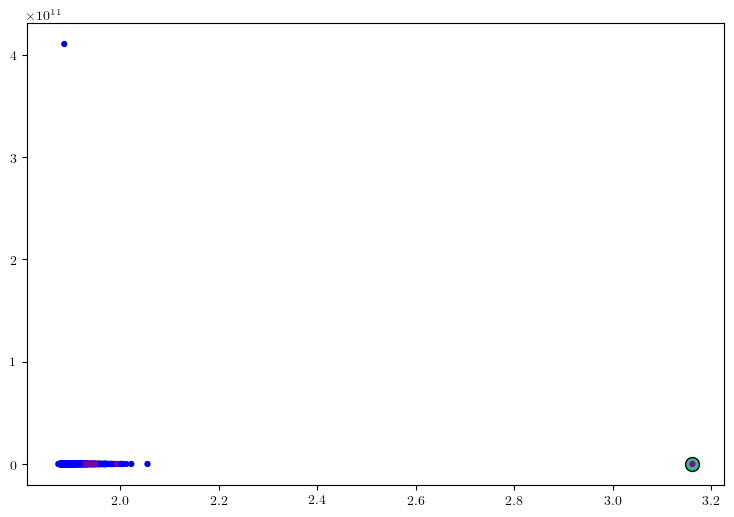

In [22]:
filename = "evalPhi.out"
filename = "evalOmega.out"
filename = "evalD0Star.out"
#filename = "eval_all_omega_opts.out"
#filename = "eval_all_d0star_opts.out"

names, errors, shapes, losses = read_file(filename)
names_filt, errors_filt, shapes_filt, losses_filt = read_file(filename)
print(len(names), len(errors), len(shapes), len(losses))

def estimation(x, a, b, c):
    return a + b*np.exp(-c*x)

p,q = sc.curve_fit(estimation, errors, losses, p0=[1, 200, 0.7], maxfev=100000)
print(p)
print(np.sqrt(np.diag(q)))
#p = [  0.21340494, 373.62622177,   0.70145433]

#Threshold of a valid model: loss < 20
#["BDTG_df15_dl3684_v0_v1_opt0", "BDTG_df15_dl3684_v1_v4_opt0", "BDTG_df15_dl3684_v0_v1_v4_opt0", "BDTG_df15_dl3684_v0_v1_v9_opt0", "BDTG_df15_dl3684_v1_v4_v9_opt0", "BDTG_df15_dl3684_v0_v1_v4_v9_opt0"]
#intervalLoss=(15, 20.8197), intervalError=(3.5, 4.03435)
newModels = plotEval(names, errors, shapes, losses, var=[], intervalLoss=(-4.0, 12.0), intervalError=(0.0, 4.0), fullNames=["BDTG_df15_dl3684_v0_v1_opt10329"], curveOffset=-0.1)

In [73]:
print(len(newModels))
print(newModels)

62
[10002, 10016, 10025, 10042, 10043, 10050, 10058, 10087, 10100, 10110, 10125, 10137, 10138, 10149, 10153, 10177, 10206, 10236, 10237, 10256, 10262, 10277, 10290, 10313, 10320, 10325, 10336, 10369, 10372, 10380, 10401, 10427, 10429, 10438, 10445, 10496, 10499, 10567, 10572, 10597, 10598, 10610, 10619, 10646, 10704, 10744, 10748, 10766, 10772, 10794, 10802, 10831, 10833, 10840, 10859, 10861, 10889, 10898, 10911, 10964, 10966, 10984]


In [52]:
#Read model properties from file, and create pandas dataframe to be able to select different model criteria to study the behaviour
#two plots per option: vs error / vs loss

def getModelOptions(fileName="/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/TMVA_regression/optionModels.out"):
    column_names = ['Id', 'VarTsf', 'NTrees', 'BoostType', 'Shrinkage', 'MaxDepth', 'SeparationType', 'nCuts', 'RndmTrees',
                    'UseNvars', 'UseBaggedBoost', 'BaggedSampleFraction', 'PruneMethod', 'PruneStrength', 'PruningValFraction']
    column_data_types = {'Id': int, 'VarTsf': str, 'NTrees': int, 'BoostType': str, 'Shrinkage': float, 'MaxDepth': int, 'SeparationType': str, 'nCuts': int, 'RndmTrees': str,
                    'UseNvars': int, 'UseBaggedBoost': str, 'BaggedSampleFraction': float, 'PruneMethod': str, 'PruneStrength': int, 'PruningValFraction': float}
    
    df = pd.read_csv(fileName, sep='$', names=column_names, dtype=column_data_types)
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    return df


def addErrorLosses(dfOptions, fileName="eval_all_phi_opts.out"):
    new_column_names = ['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149',
                         'Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']
    
    for column in new_column_names:
        dfOptions[column] = np.nan
    
    with open(fileName, 'r') as file:
        for line in file:
            parts = line.strip().split()
            #print(parts)
            if parts[0] != "RECO":
                identifier = int(parts[0].split("_")[-1].replace("opt", ""))
                variables = "v" + "".join([v.replace("v", "") for v in parts[0].split("_")[3:-1]])
                error = float(parts[1])
                loss = float(parts[3])

                dfOptions.loc[dfOptions['Id'] == identifier, 'Error_' + variables] = error
                dfOptions.loc[dfOptions['Id'] == identifier, 'Loss_' + variables] = loss
                #print(identifier, variables, error, loss)
    return dfOptions

pddf = getModelOptions()
pddf = addErrorLosses(pddf)
#display(pddf)
maxError, maxLoss = 4.03435, 20.8197
maxError=5.0
#pddf = pddf[10 + 0.2134 + 373.626*np.exp(-0.701*pddf["Error_v014"]) < pddf["Loss_v014"]]
pddf = pddf[(pddf["Error_v01"] < maxError) | (pddf["Error_v14"] < maxError) | (pddf["Error_v014"] < maxError) | (pddf["Error_v019"] < maxError) | (pddf["Error_v149"] < maxError) | (pddf["Error_v0149"] < maxError)]
print(len(pddf))
#pddf = pddf[(pddf["Loss_v01"] < maxLoss) | (pddf["Loss_v14"] < maxLoss) | (pddf["Loss_v014"] < maxLoss) | (pddf["Loss_v019"] < maxLoss) | (pddf["Loss_v149"] < maxLoss) | (pddf["Loss_v0149"] < maxLoss)]
print(len(pddf))
#intervalLoss=(15, 20.8197), intervalError=(3.5, 4.03435)
pddf = pddf[pddf["Error_v014"].notna()]
#pddf = pddf[pddf["UseBaggedBoost"] == "T"]
print(len(pddf))
pddf = pddf[pddf["Id"].isin(newModels)]
print(len(pddf))
display(pddf)

plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v01'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v01'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v14'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v14'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v014'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v014'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v019'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v019'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v149'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v149'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v0149'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v0149'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v01'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v01'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v14'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v14'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v014'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v014'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v019'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v019'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v149'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v149'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v0149'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v0149'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.xlabel('Mean error in pt (predicted - gen) GeV')
plt.ylabel('Loss')
plt.title('Mean PT error pt vs Loss')
xmin, xmax, xsep = 2.5, 6, 0.5
#xmin, xmax, xsep = 6.2, 6.35, 0.01
ymin, ymax, ysep = 5, 60, 5
#ymin, ymax, ysep = 172, 180, 1
#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)
#plt.yticks(np.arange(ymin, ymax+0.001, ysep))
#plt.xticks(np.arange(xmin, xmax+0.001, xsep))
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'eval_all_phi_opts.out'

In [113]:
pddf = pddf[pddf["NTrees"] >= 0]
pddf = pddf[pddf["Shrinkage"] <= 0.6]
pddf = pddf[pddf["MaxDepth"] >= 5]
plotOption(pddf, "NTrees", xmin = 0, xmax = 5000, step_size = 200, nbins = 50)
plotOption(pddf, "Shrinkage", xmin = 0, xmax = 0.6, step_size = 0.05, nbins = 50)
plotOption(pddf, "MaxDepth", xmin = 4, xmax = 10, step_size = 1, nbins = 50)
plotOption(pddf, "nCuts", xmin = 0, xmax = 100, step_size = 10, nbins = 50)
plotOption(pddf, "RndmTrees", xmin = 0, xmax = 2, step_size = 1, nbins = 5)
plotOption(pddf, "UseNvars", xmin = 0, xmax = 100, step_size = 10, nbins = 50)
plotOption(pddf, "UseBaggedBoost", xmin = 0, xmax = 2, step_size = 1, nbins = 5)
plotOption(pddf[pddf["UseBaggedBoost"] == "T"], "BaggedSampleFraction", xmin = 0, xmax = 5, step_size = 0.1, nbins = 50)
plotOption(pddf, "PruneMethod", xmin = 0, xmax = 2, step_size = 1, nbins = 5)
plotOption(pddf[pddf["PruneMethod"] != "NoPruning"], "PruneStrength", xmin = 0, xmax = 100, step_size = 10, nbins = 50)
plotOption(pddf[pddf["PruneMethod"] != "NoPruning"], "PruningValFraction", xmin = 0, xmax = 2, step_size = 0.1, nbins = 50)

ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

25
RECO                     	3.162 (-47.0\%)	-1.321	18.188 (+302.8\%)
BDTG_df7_dl3684_v0_v1_opt15064	1.88 (-68.5\%)	1.735	14.812 (+228.0\%)
BDTG_df7_dl3684_v0_v1_opt15070	1.885 (-68.4\%)	-1.368	14.812 (+228.0\%)
BDTG_df7_dl3684_v0_v1_opt15110	1.88 (-68.5\%)	1.892	14.812 (+228.0\%)
BDTG_df7_dl3684_v0_v1_opt15136	1.877 (-68.5\%)	0.696	14.688 (+225.3\%)
BDTG_df7_dl3684_v0_v1_opt15241	1.884 (-68.4\%)	-0.893	14.812 (+228.0\%)
BDTG_df7_dl3684_v0_v1_opt15257	1.881 (-68.5\%)	-3.675	14.812 (+228.0\%)
BDTG_df7_dl3684_v0_v1_opt15285	1.882 (-68.4\%)	-0.408	14.812 (+228.0\%)
BDTG_df7_dl3684_v0_v1_opt15332	1.882 (-68.4\%)	-0.964	14.75 (+226.6\%)
BDTG_df7_dl3684_v0_v1_opt15353	1.883 (-68.4\%)	1.441	14.812 (+228.0\%)
BDTG_df7_dl3684_v0_v1_opt15359	1.879 (-68.5\%)	-2.778	14.75 (+226.6\%)
BDTG_df7_dl3684_v0_v1_opt15373	1.879 (-68.5\%)	-1.129	14.812 (+228.0\%)
BDTG_df7_dl3684_v0_v1_opt15458	1.88 (-68.5\%)	0.504	14.75 (+226.6\%)
BDTG_df7_dl3684_v0_v1_opt15480	1.881 (-68.4\%)	-3.65	14.75 (+226.6\%)
BDTG_df

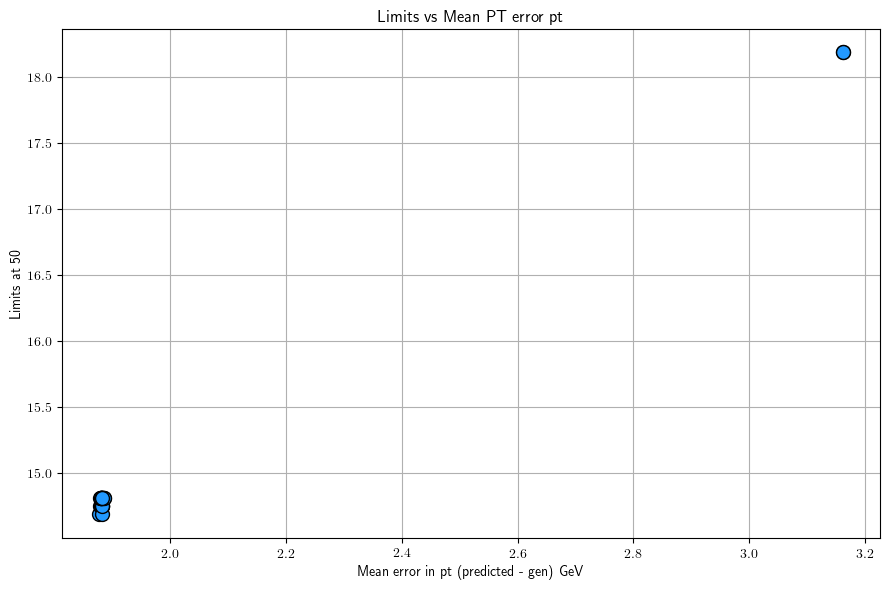

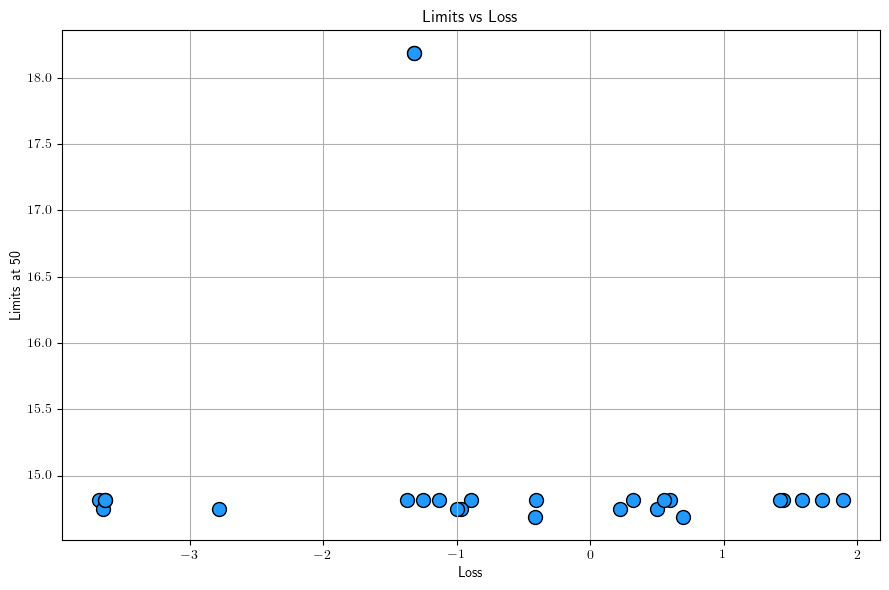

In [23]:
filename = "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/FITS_marti/limits_Phi3.out"
filename = "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/FITS_marti/limits_Omega.out"
filename = "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/FITS_marti/limits_D0Star.out"
names, errors, loss, limits = [], [], [], []
with open(filename, 'r') as file:
    for line in file:
        # Split the line into its components using whitespace as the delimiter
        parts = line.strip().split()
        for i, zipped in enumerate(zip(names_filt, errors_filt, losses_filt)):
            if zipped[0] == parts[0]:
                names.append(parts[0])
                errors.append(float(zipped[1]))
                loss.append(float(zipped[2]))
                limits.append(float(parts[1]))

print(len(names))

annotations = []
namesAnn=[]


for n, e, l, lim  in zip(names, errors, loss, limits):
    if (lim < 135 and e < 4) or n in namesAnn:
        annotations.append([n, e, l, lim])
for a in annotations:
    print("{}\t{} ({:+.1f}\%)\t{}\t{} ({:+.1f}\%)".format(a[0].ljust(25), round(a[1], 3), (a[1]/5.962538036196778-1)*100, round(a[2], 3), round(a[3], 3), (a[3]/4.5156-1)*100))

#FOR Error
plt.figure(figsize=(9, 6))
c = 0
for n, e, l, lims  in zip(names, errors, loss, limits):
    if n == "RECO":
        plt.scatter(e, lims, color="#33bb88", s=100, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_")) == 3:
        plt.scatter(e, lims, color="#ffcc00", s=40, alpha=1.0, edgecolor="#665100")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df15":
        plt.scatter(e, lims, color="#CC0000", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df47":
        plt.scatter(e, lims, color="#00CC00", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df79":
        plt.scatter(e, lims, color="#6666AA", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df111":
        plt.scatter(e, lims, color="#CC00CC", s=40, alpha=1.0, edgecolor="#000000")
        c += 1

for n, e, l, lim in annotations:
    plt.scatter(e, lim, color="#2299ff", s=100, alpha=1.0, edgecolor="#000000")
    #plt.annotate(n, (e, lim), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
print(c)
plt.xlabel('Mean error in pt (predicted - gen) GeV')
plt.ylabel('Limits at 50%')
plt.title('Limits vs Mean PT error pt')
plt.grid()
#plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

#FOR LOSS
plt.figure(figsize=(9, 6))
for n, e, l, lims  in zip(names, errors, loss, limits):
    if n == "RECO":
        plt.scatter(l, lims, color="#33bb88", s=100, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_")) == 3:
        plt.scatter(l, lims, color="#ffcc00", s=40, alpha=1.0, edgecolor="#665100")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df15":
        plt.scatter(l, lims, color="#CC0000", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df47":
        plt.scatter(l, lims, color="#00CC00", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df79":
        plt.scatter(l, lims, color="#6666AA", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df111":
        plt.scatter(l, lims, color="#CC00CC", s=40, alpha=1.0, edgecolor="#000000")
        c += 1

for n, e, l, lim in annotations:
    plt.scatter(l, lim, color="#2299ff", s=100, alpha=1.0, edgecolor="#000000")
    #plt.annotate(n, (l, lim), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
plt.xlabel('Loss')
plt.ylabel('Limits at 50%')
plt.title('Limits vs Loss')
plt.grid()
#plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [24]:
models = np.stack((names, errors, loss, limits), axis=0)
sorted_indices = np.argsort(models[3])

# Use these indices to rearrange the rows of the matrix
sorted_matrix = models[:, sorted_indices].T


for element in sorted_matrix[:150]:
    if(float(element[2]) < 135):
        print("{}\t{}\t{}\t{}".format(element[3], element[0].ljust(25), element[1], element[2]))


14.6875	BDTG_df7_dl3684_v0_v1_opt15136	1.8773788032514807	0.6960861650352534
14.6875	BDTG_df7_dl3684_v0_v1_opt15553	1.8820798689340805	-0.4094468049695932
14.75	BDTG_df7_dl3684_v0_v1_opt15458	1.8800402770737963	0.5042286181151672
14.75	BDTG_df7_dl3684_v0_v1_opt15332	1.8820330495327018	-0.9636200908688233
14.75	BDTG_df7_dl3684_v0_v1_opt15702	1.8811856122940953	0.22300382871264102
14.75	BDTG_df7_dl3684_v0_v1_opt15359	1.8788536956329385	-2.77800762562054
14.75	BDTG_df7_dl3684_v0_v1_opt15525	1.8821346074471226	-0.999611951129455
14.75	BDTG_df7_dl3684_v0_v1_opt15480	1.8812120122393656	-3.6504731304809157
14.8125	BDTG_df7_dl3684_v0_v1_opt15871	1.8784913554690685	0.5527379582459653
14.8125	BDTG_df7_dl3684_v0_v1_opt15846	1.8846200246980123	-3.633874708516021
14.8125	BDTG_df7_dl3684_v0_v1_opt15829	1.8830873736308547	1.588285996579351
14.8125	BDTG_df7_dl3684_v0_v1_opt15798	1.8804451014186743	0.3234002383520693
14.8125	BDTG_df7_dl3684_v0_v1_opt15793	1.8810282529439961	0.5944482478815161
14.8125	B

In [101]:
filename = "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/FITS_marti/doneModels.txt"
doneNames = []
with open(filename, 'r') as file:
    for line in file:
        # Split the line into its components using whitespace as the delimiter
        parts = line.strip().split()
        doneNames.append(parts[0])

doneNames = list(set(doneNames))
newModels = list(set(newModels))
allModels = list(set(newModels + doneNames))
print(len(doneNames))
print(len(newModels))
print(len(allModels))

remainingModels = list(set(newModels).difference(set(doneNames)))
print(len(remainingModels))
for v in remainingModels:
    print(v)






96
43
109
13
BDTG_df15_dl3684_v3_v4_v11
BDTG_df15_dl3684_v3_v4_v9_v10_v11
BDTG_df15_dl3684_v0_v1_v4_v10
BDTG_df15_dl3684_v0_v4_v10_v11
BDTG_df15_dl3684_v3_v4_v10
BDTG_df15_dl3684_v0_v1_v4_v9_v10
BDTG_df15_dl3684_v3_v4_v9_v10
BDTG_df15_dl3684_v0_v1_v9_v10
BDTG_df15_dl3684_v3_v4_v9
BDTG_df15_dl3684_v0_v4_v9_v11
BDTG_df15_dl3684_v1_v4_v9_v10
BDTG_df15_dl3684_v0_v4_v9_v10_v11
BDTG_df15_dl3684_v3_v4_v9_v11
